# Bank Marketing Campaign Analysis

This notebook analyzes a bank marketing campaign dataset and improves a classification model to predict customer subscription ("y" variable). The focus is on data cleaning, handling class imbalance, and building a robust model.

## 1. Import Libraries

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

## 2. Load Dataset

In [3]:
# Load the dataset
df_orig = pd.read_csv("Bank_Marketing_Prediction/Coding/bank-full.csv", delimiter=';')
df_orig.head(10)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
5,35,management,married,tertiary,no,231,yes,no,unknown,5,may,139,1,-1,0,unknown,no
6,28,management,single,tertiary,no,447,yes,yes,unknown,5,may,217,1,-1,0,unknown,no
7,42,entrepreneur,divorced,tertiary,yes,2,yes,no,unknown,5,may,380,1,-1,0,unknown,no
8,58,retired,married,primary,no,121,yes,no,unknown,5,may,50,1,-1,0,unknown,no
9,43,technician,single,secondary,no,593,yes,no,unknown,5,may,55,1,-1,0,unknown,no


In [4]:
# Making a copy
data = df_orig.copy()

## 3. Data Cleaning

### Key Steps:
- Add a new feature to indicate previous contact.
- Encode the target variable (`y`).

In [5]:
# Encode target variable `y` as binary: 'no' -> 0, 'yes' -> 1
data['y'] = data['y'].map({'no': 0, 'yes': 1})

# Add a flag for previous contact
data['was_contacted_before'] = (data['pdays'] != -1).astype(int)

# One-hot encode categorical variables
categorical_features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
data_encoded = pd.get_dummies(data, columns=categorical_features, drop_first=True)
data_encoded.head()

,age,balance,day,duration,campaign,pdays,previous,y,was_contacted_before,job_blue-collar,...,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown
0,58,2143,5,261,1,-1,0,0,0,False,...,False,False,False,True,False,False,False,False,False,True
1,44,29,5,151,1,-1,0,0,0,False,...,False,False,False,True,False,False,False,False,False,True
2,33,2,5,76,1,-1,0,0,0,False,...,False,False,False,True,False,False,False,False,False,True
3,47,1506,5,92,1,-1,0,0,0,True,...,False,False,False,True,False,False,False,False,False,True
4,33,1,5,198,1,-1,0,0,0,False,...,False,False,False,True,False,False,False,False,False,True


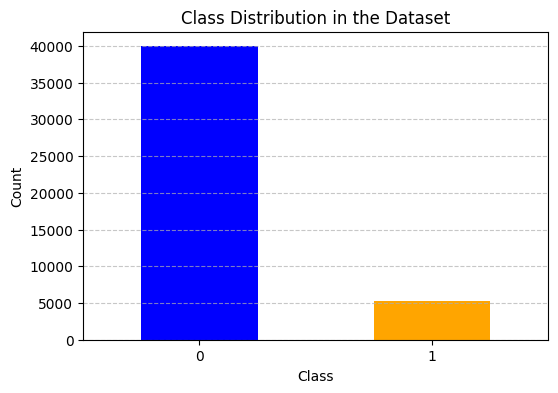

In [7]:
# Count occurrences of each class (target column 'y')
class_counts = data['y'].value_counts()

# Plot the imbalance
plt.figure(figsize=(6, 4))
class_counts.plot(kind='bar', color=['blue', 'orange'])
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Class Distribution in the Dataset")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

### Data is very imbalanced.  First, let's model before balancing.

## 4. Train-Test Split

### Ensures the model is tested on unseen data to measure generalizability.

In [8]:
# Split the data into features (X) and target (y)
X = data_encoded.drop('y', axis=1)
y = data_encoded['y']

# Train-test split 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=314, stratify=y)

## 5. Model Training
- **Logistic Regression**: A simple, interpretable baseline that performs well with linearly separable data.  
- **Random Forest**: A robust, ensemble-based model that captures complex patterns and feature interactions.  
- **XGBoost**: An optimized boosting model with high accuracy but more computational overhead.  

In [9]:
# Initialize models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=314),
    "Random Forest": RandomForestClassifier(random_state=314, n_estimators=100),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=314)
}

In [11]:
# Train each model
for name, model in models.items():
    model.fit(X_train, y_train)
    print(f"{name} trained successfully!")

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression trained successfully!
Random Forest trained successfully!


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:24:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost trained successfully!


## 6. Model Evaluation

In [12]:
# Evaluation
for name, model in models.items():
    y_pred = model.predict(X_test)  # Adjusted from X_test_final to X_test
    y_proba = model.predict_proba(X_test)[:, 1]  # For ROC AUC

    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    auc_score = roc_auc_score(y_test, y_proba)
    print(f"\n{name} Performance:")
    print("Accuracy:", accuracy)
    print("ROC AUC:", auc_score)
    print("Classification Report:\n", classification_report(y_test, y_pred))


Logistic Regression Performance:
Accuracy: 0.9046776512219397
ROC AUC: 0.9110683666089419
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.98      0.95      7985
           1       0.69      0.34      0.45      1058

    accuracy                           0.90      9043
   macro avg       0.80      0.66      0.70      9043
weighted avg       0.89      0.90      0.89      9043


Random Forest Performance:
Accuracy: 0.9087692137564968
ROC AUC: 0.9364316126764148
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.98      0.95      7985
           1       0.70      0.39      0.50      1058

    accuracy                           0.91      9043
   macro avg       0.81      0.68      0.73      9043
weighted avg       0.90      0.91      0.90      9043


XGBoost Performance:
Accuracy: 0.9131925246046666
ROC AUC: 0.9382819629906262
Classification Report:
               preci

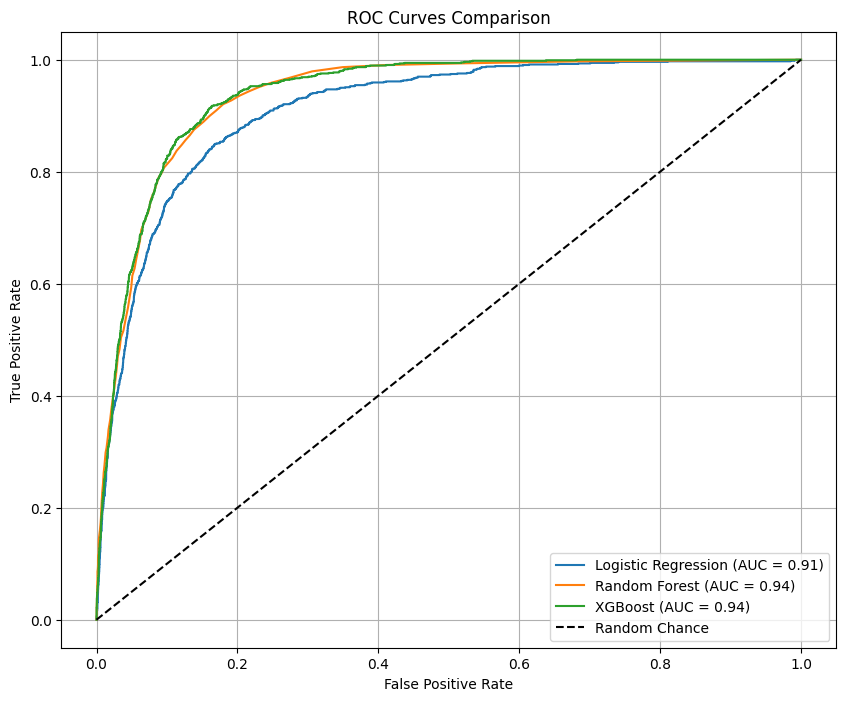

In [13]:
# Plot ROC Curves for all models
plt.figure(figsize=(10, 8))
for name, model in models.items():
    y_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc_score(y_test, y_proba):.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend()
plt.grid(True)
plt.show()

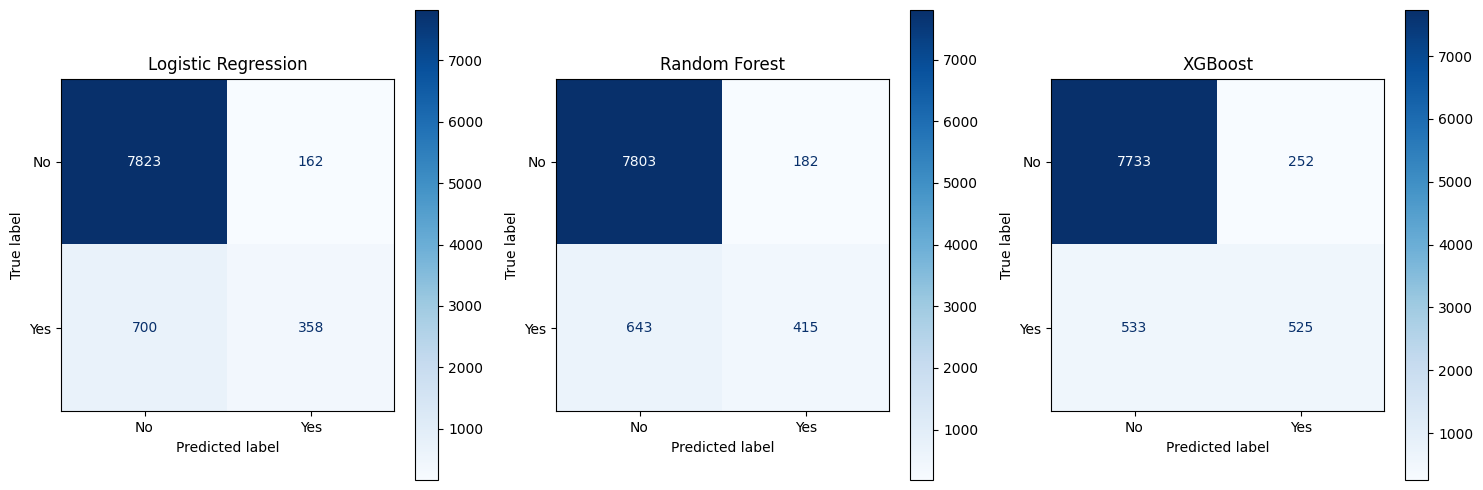

In [16]:
# Generate and display confusion matrices for each trained model
fig, axes = plt.subplots(1, len(models), figsize=(15, 5))

for ax, (name, model) in zip(axes, models.items()):
    y_pred = model.predict(X_test)  # Get predictions
    cm = confusion_matrix(y_test, y_pred)  # Compute confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No", "Yes"])
    disp.plot(ax=ax, cmap="Blues", values_format="d")
    ax.set_title(name)

plt.tight_layout()
plt.show()

### Due to imbalanced data, the "Yes" labels were not predicted well.  There is clear bias for "No" label.  SMOTE will be used to balance this out.

## 7. SMOTE (Addressing Class Imbalance)

In [17]:
# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=314)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Resample train-test split
X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

In [18]:
# Train each model
for name, model in models.items():
    model.fit(X_train_resampled, y_train_resampled)
    print(f"{name} trained successfully!")

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression trained successfully!
Random Forest trained successfully!


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:37:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost trained successfully!


In [19]:
# Evaluation
for name, model in models.items():
    y_pred = model.predict(X_test_resampled)  # Adjusted from X_test_final to X_test
    y_proba = model.predict_proba(X_test_resampled)[:, 1]  # For ROC AUC

    # Metrics
    accuracy = accuracy_score(y_test_resampled, y_pred)
    auc_score = roc_auc_score(y_test_resampled, y_proba)
    print(f"\n{name} Performance:")
    print("Accuracy:", accuracy)
    print("ROC AUC:", auc_score)
    print("Classification Report:\n", classification_report(y_test_resampled, y_pred))


Logistic Regression Performance:
Accuracy: 0.9276723652075897
ROC AUC: 0.9752830802494156
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.93      0.93      7985
           1       0.93      0.92      0.93      7984

    accuracy                           0.93     15969
   macro avg       0.93      0.93      0.93     15969
weighted avg       0.93      0.93      0.93     15969


Random Forest Performance:
Accuracy: 0.9436408040578621
ROC AUC: 0.9902122341113033
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.95      0.94      7985
           1       0.95      0.94      0.94      7984

    accuracy                           0.94     15969
   macro avg       0.94      0.94      0.94     15969
weighted avg       0.94      0.94      0.94     15969


XGBoost Performance:
Accuracy: 0.9421378921660718
ROC AUC: 0.9889596349869434
Classification Report:
               preci

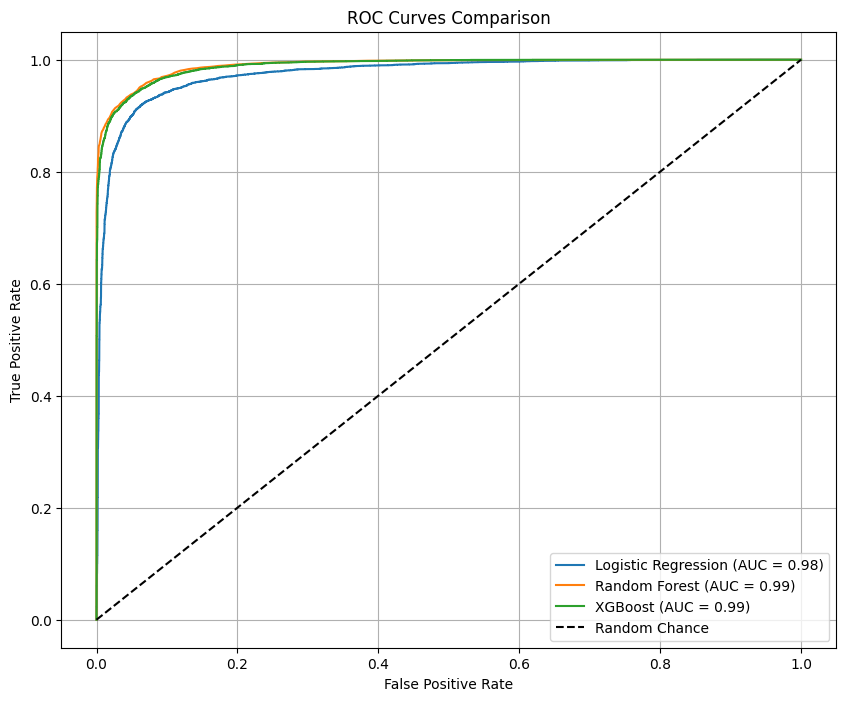

In [20]:
# Plot ROC Curves for all models (RESAMPLED)
plt.figure(figsize=(10, 8))
for name, model in models.items():
    y_proba = model.predict_proba(X_test_resampled)[:, 1]
    fpr, tpr, _ = roc_curve(y_test_resampled, y_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc_score(y_test_resampled, y_proba):.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend()
plt.grid(True)
plt.show()

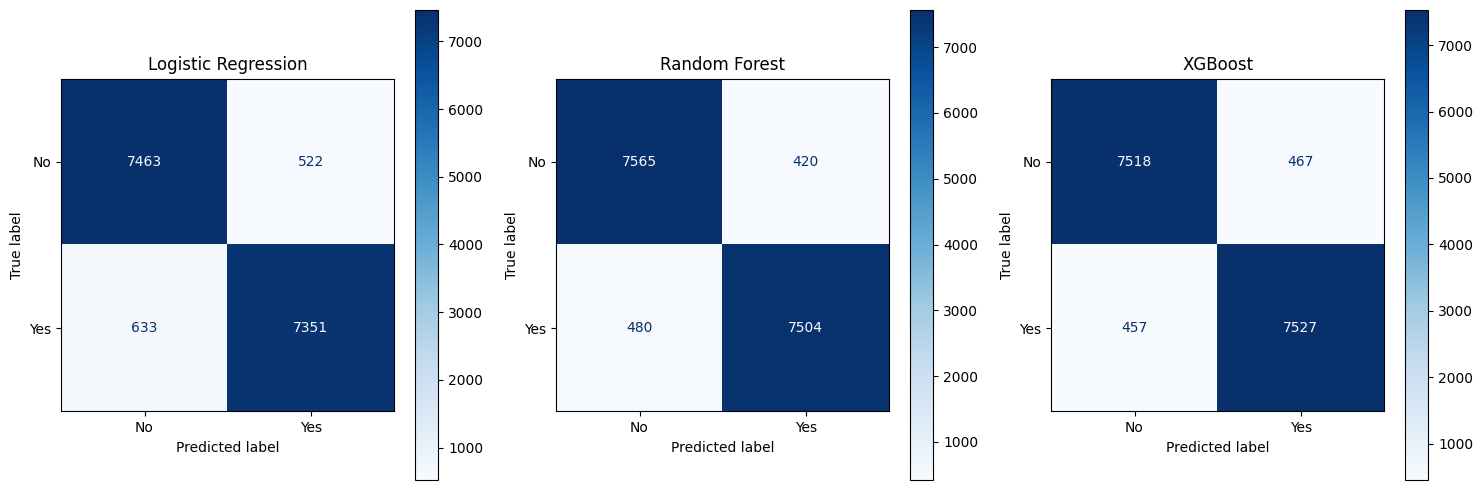

In [21]:
# Generate and display confusion matrices for each trained model
fig, axes = plt.subplots(1, len(models), figsize=(15, 5))

for ax, (name, model) in zip(axes, models.items()):
    y_pred = model.predict(X_test_resampled)  # Get predictions
    cm = confusion_matrix(y_test_resampled, y_pred)  # Compute confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No", "Yes"])
    disp.plot(ax=ax, cmap="Blues", values_format="d")
    ax.set_title(name)

plt.tight_layout()
plt.show()

## 8. Results and Insights
### Model Selection: Random Forest
After evaluating multiple models (Logistic Regression, XGBoost, and Random Forest), I chose Random Forest because:
1. It achieved the highest accuracy, precision, and recall.
2. Unlike Logistic Regression, it captures complex feature interactions without assuming linear relationships.

### Class 0 (No to Subscription):
* Precision (0.94): Out of all the instances predicted as no, 94% were correctly identified as no.
* Recall (0.95): The model successfully identified 95% of actual no subscription.
* F1-Score (0.94): The F1-score, which balances precision and recall, is very high, indicating excellent performance for predicting a no to the subscription.
### Class 1 (Yes to Subscription):
* Precision (0.95): Out of all the instances predicted as diabetic, 95% were correctly classified as diabetic.
* Recall (0.94): The model successfully identified 94% of actual no subscription.
* F1-Score (0.94): The F1-score, which balances precision and recall, is very high, indicating excellent performance for predicting a yes to the subscription.

### Overall, all models seems to have done well with SMOTE method.

## 9. Hyperparameter Tuning
*   Randomized Search







In [22]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

random_search = RandomizedSearchCV(RandomForestClassifier(random_state=314),
                                   param_distributions=param_grid,
                                   n_iter=10, #minimized to make run in colab faster
                                   scoring='f1',
                                   cv=5,
                                   n_jobs=-1)
random_search.fit(X_train_resampled, y_train_resampled)

print("Best Parameters:", random_search.best_params_)

# Train final model with best parameters
final_rf = RandomForestClassifier(**random_search.best_params_, random_state=314)
final_rf.fit(X_train_resampled, y_train_resampled)

# Evaluate on test set
y_pred_rf = final_rf.predict(X_test_resampled)
accuracy_rf = accuracy_score(y_test_resampled, y_pred)

Best Parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 10}


In [23]:
classification_report_optimized = classification_report(y_test_resampled, y_pred_rf)
print("\nClassification Report:")
print(classification_report_optimized)


Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.92      0.93      7985
           1       0.92      0.94      0.93      7984

    accuracy                           0.93     15969
   macro avg       0.93      0.93      0.93     15969
weighted avg       0.93      0.93      0.93     15969



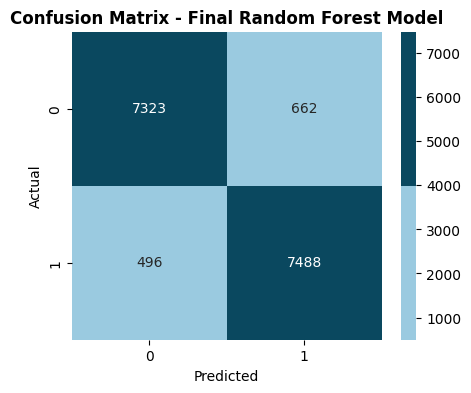

In [32]:
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test_resampled, y_pred_rf),
            annot=True, fmt='d', cmap=sns.color_palette(["#9acae0", "#0a485f"], as_cmap=True))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Final Random Forest Model", fontsize=12, fontweight='bold')
plt.show()

In [25]:
from sklearn.model_selection import cross_val_score
cross_val_score(final_rf, X_test_resampled, y_test_resampled, cv=5, scoring='f1',verbose=1,n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.7s finished


array([0.92398022, 0.92365457, 0.92948121, 0.92584549, 0.92483761])

### Cross validation scores out of 5 folds, shows there is no major overfitting.

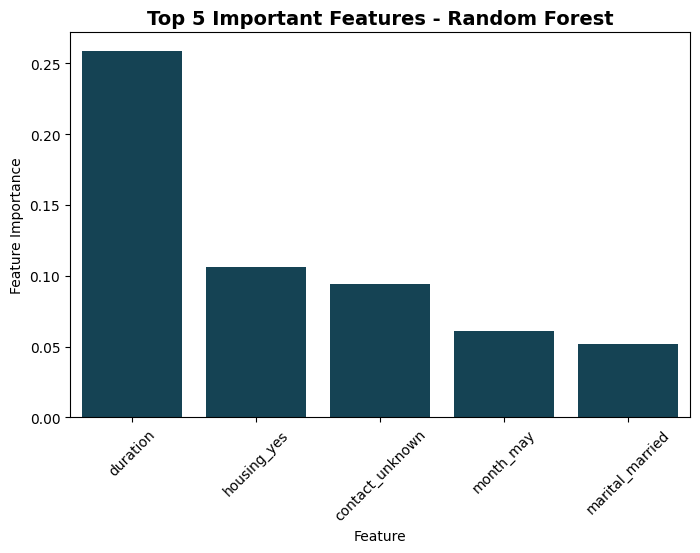

In [26]:
# Get feature importances
importances = final_rf.feature_importances_
feature_names = X_train_resampled.columns

# Create a DataFrame
feat_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_importances = feat_importances.sort_values(by="Importance", ascending=False)

# Plot the top 5 features
plt.figure(figsize=(8,5))
sns.barplot(x=feat_importances[:5]['Feature'], y=feat_importances[:5]['Importance'], color="#0a485f")
plt.xlabel("Feature")
plt.ylabel("Feature Importance")
plt.title("Top 5 Important Features - Random Forest", fontsize=14, fontweight='bold')
plt.xticks(rotation=45)
plt.show()

### Probability of a customer subscribing based on random forest

In [27]:
y_probs = final_rf.predict_proba(X_test_resampled)[:, 1]  # Probabilities for the positive class

In [28]:
X_test_resampled["subscription_probability"] = y_probs
sorted_customers = X_test_resampled.sort_values(by="subscription_probability", ascending= False)

In [29]:
sorted_customers.head(10)  # Top 10 highest probability customers

,age,balance,day,duration,campaign,pdays,previous,was_contacted_before,job_blue-collar,job_entrepreneur,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown,subscription_probability
64313,37,197,14,532,1,90,2,1,False,False,...,False,False,False,False,False,False,False,True,False,0.964576
58375,36,209,7,585,1,93,1,1,False,False,...,False,False,False,False,False,False,False,True,False,0.964466
46498,34,1162,10,759,1,186,2,1,False,False,...,False,False,False,False,False,False,False,True,False,0.964373
61732,35,3298,13,601,1,187,1,1,False,False,...,False,False,False,False,False,False,False,True,False,0.964369
48790,34,739,13,1822,3,101,1,0,False,False,...,False,False,False,False,False,False,False,False,False,0.964327
53796,38,5007,9,943,1,154,9,1,False,False,...,False,False,False,False,False,False,False,True,False,0.964071
57561,40,465,8,1086,1,36,1,0,False,False,...,False,False,False,False,False,False,False,False,False,0.963975
71160,36,426,22,561,2,122,2,1,False,False,...,False,False,False,False,False,False,False,True,False,0.963959
65594,29,1143,17,804,1,184,3,1,False,False,...,False,False,False,False,False,False,False,True,False,0.963806
65602,30,3428,19,526,1,178,2,1,False,False,...,False,False,False,False,False,False,False,True,False,0.963802
